In [ ]:
!pip install --upgrade torch torchvision torchaudio

In [ ]:
# Install diffusers from the main branch until future stable release
!pip install git+https://github.com/huggingface/diffusers.git

In [3]:
!pip show torch

Name: torch
Version: 2.8.0+cu126
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [4]:
!nvidia-smi

Sun Aug 31 01:53:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
import os
from pathlib import Path

CACHE_DIR = Path('/content/drive/MyDrive/artifacts/flux_kontext_mega_cache')

# Set environment variables
os.environ["TORCHINDUCTOR_FX_GRAPH_CACHE"] = "1"
os.environ["CUDA_CACHE_PATH"] = str(CACHE_DIR / ".nv_cache")
os.environ["TORCHINDUCTOR_CACHE_DIR"] = str(CACHE_DIR / ".inductor_cache")
os.environ["TRITON_CACHE_DIR"] = str(CACHE_DIR / ".triton_cache")

# Optional: Enable debug logs for PyTorch compilation/cache behavior
os.environ["TORCH_LOGS"] = "+torch._inductor.codecache"
mega_cache_path = CACHE_DIR / ".mega_cache"

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
import torch
torch.cuda.get_device_capability()

(8, 0)

In [8]:
import torch
from diffusers import FluxKontextPipeline, TorchAoConfig
from diffusers.quantizers import PipelineQuantizationConfig
from diffusers.utils import load_image
# from cache_dit.cache_factory import apply_cache_on_pipe, CacheType

pipe = FluxKontextPipeline.from_pretrained("black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
input_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png")

In [ ]:
%%time
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]


  0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 22.3 s, sys: 9.09 s, total: 31.3 s
Wall time: 31.4 s


Compile graphs (takes approx 15 min)

In [10]:
# If compilation has previously been performed
if mega_cache_path.exists():
    with open(mega_cache_path, "rb") as f:
        artifact_bytes = f.read()
    if artifact_bytes:
        torch.compiler.load_cache_artifacts(artifact_bytes)
        print("Loaded torch mega-cache artifacts")
else:
    print("Torch mega-cache artifacts not found, will generate new cache")

W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294] Failed to un-pickle cache artifacts
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294] Traceback (most recent call last):
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294]   File "/usr/local/lib/python3.12/dist-packages/torch/compiler/_cache.py", line 288, in deserialize
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294]     AppendingByteSerializer.to_list(
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294]   File "/usr/local/lib/python3.12/dist-packages/torch/utils/_appending_byte_serializer.py", line 122, in to_list
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294]     reader = BytesReader(data)
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294]              ^^^^^^^^^^^^^^^^^
W0831 01:59:07.368000 5340 torch/compiler/_cache.py:294]   File "/usr/local/lib/python3.12/dist-packages/torch/utils/_appending_byte_serializer.py", line 55, in __init__
W0831 01:59:07.368000 5340 torch/compiler/_cache

Loaded torch mega-cache artifacts


In [11]:
# The order of events here matters
%%time
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_check_all_directions = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.disable_progress = False
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.shape_padding = True

pipe.transformer.fuse_qkv_projections()
pipe.vae.fuse_qkv_projections()
pipe.transformer.to(memory_format=torch.channels_last)
pipe.vae.to(memory_format=torch.channels_last)

pipe.transformer = torch.compile(
    pipe.transformer, mode="max-autotune-no-cudagraphs", dynamic=True
)
pipe.vae.decode = torch.compile(
    pipe.vae.decode, mode="max-autotune-no-cudagraphs", dynamic=True
)

pipe(
  image=input_image,
  prompt="Add a hat to the cat",
)

  0%|          | 0/28 [00:00<?, ?it/s]

V0831 02:01:19.815000 5340 torch/_inductor/codecache.py:1312] [0/0_1] fx graph cache key fjfnop6w2pwjkioy74boo5mii6okgi66t3el4slnmpp7awo4hfxk post-load guards: [ShapeGuard(expr=Eq(s33, 64), sloc=SLoc(framework_loc=<FrameSummary file /usr/local/lib/python3.12/dist-packages/torch/_meta_registrations.py, line 2417 in meta_mm>, maybe_user_loc='return F.linear(input, self.weight, self.bias)  # nn/modules/linear.py:125 in forward'), size_oblivious=False), ShapeGuard(expr=Eq(s13, 768), sloc=SLoc(framework_loc=<FrameSummary file /usr/local/lib/python3.12/dist-packages/torch/_meta_registrations.py, line 2417 in meta_mm>, maybe_user_loc='return F.linear(input, self.weight, self.bias)  # nn/modules/linear.py:125 in forward'), size_oblivious=False), ShapeGuard(expr=Eq(s2, 4096), sloc=SLoc(framework_loc=<FrameSummary file /usr/local/lib/python3.12/dist-packages/torch/_meta_registrations.py, line 2417 in meta_mm>, maybe_user_loc='return F.linear(input, self.weight, self.bias)  # nn/modules/linear.py

CPU times: user 2min 40s, sys: 27 s, total: 3min 7s
Wall time: 19min 15s


FluxPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7EA58C437AA0>])

In [14]:
from pprint import pprint
import gc
gc.collect()
torch.cuda.empty_cache()
pprint(torch.cuda.memory_summary(device=None, abbreviated=False))

('|===========================================================================|\n'
 '|                  PyTorch CUDA memory summary, device ID 0                 '
 '|\n'
 '|---------------------------------------------------------------------------|\n'
 '|            CUDA OOMs: 0            |        cudaMalloc retries: 1         '
 '|\n'
 '|===========================================================================|\n'
 '|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  '
 '|\n'
 '|---------------------------------------------------------------------------|\n'
 '| Allocated memory      |  36307 MiB |  38363 MiB | 557431 MiB | 521123 MiB '
 '|\n'
 '|       from large pool |  36289 MiB |  38342 MiB | 550991 MiB | 514701 MiB '
 '|\n'
 '|       from small pool |     17 MiB |     24 MiB |   6439 MiB |   6421 MiB '
 '|\n'
 '|---------------------------------------------------------------------------|\n'
 '| Active memory         |  36307 MiB |  38363 MiB | 557431 Mi

In [15]:
pipe.transformer

OptimizedModule(
  (_orig_mod): FluxTransformer2DModel(
    (pos_embed): FluxPosEmbed()
    (time_text_embed): CombinedTimestepGuidanceTextProjEmbeddings(
      (time_proj): Timesteps()
      (timestep_embedder): TimestepEmbedding(
        (linear_1): Linear(in_features=256, out_features=3072, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=3072, out_features=3072, bias=True)
      )
      (guidance_embedder): TimestepEmbedding(
        (linear_1): Linear(in_features=256, out_features=3072, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=3072, out_features=3072, bias=True)
      )
      (text_embedder): PixArtAlphaTextProjection(
        (linear_1): Linear(in_features=768, out_features=3072, bias=True)
        (act_1): SiLU()
        (linear_2): Linear(in_features=3072, out_features=3072, bias=True)
      )
    )
    (context_embedder): Linear(in_features=4096, out_features=3072, bias=True)
    (x_embedder): Linear(in_features=64, out_fea

# Only use this section if compiling artifacts for the first time

In [16]:
# Use for first time compilation to get artifacts
artifact_bytes, cache_info  = torch.compiler.save_cache_artifacts()

In [17]:
with open(mega_cache_path, "wb") as f:
    f.write(artifact_bytes)

In [18]:
with open(mega_cache_path, "rb") as f:
    artifact_bytes_2 = f.read()

if artifact_bytes_2:
    assert artifact_bytes == artifact_bytes_2
    # torch.compiler.load_cache_artifacts(artifact_bytes)

In [22]:
# sanity check
!ls -al /content/drive/MyDrive/artifacts/flux_kontext_mega_cache
!ls -al /content/drive/MyDrive/artifacts/flux_kontext_mega_cache/.mega_cache

total 197962
drwx------  103 root root      4096 Jul 30 01:28 .inductor_cache
-rw-------    1 root root 202699921 Aug 31 02:19 .mega_cache
drwx------    2 root root      4096 Jul 30 01:27 .nv_cache
drwx------ 1336 root root      4096 Aug 31 02:16 .triton_cache
-rw------- 1 root root 202699921 Aug 31 02:19 /content/drive/MyDrive/artifacts/flux_kontext_mega_cache/.mega_cache


# Run inference once more to check speedup (22s vs 31s)

In [19]:
import time
start = time.time()
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]
end = time.time() - start
print(f"Inference time: {end:.2f} seconds")

  0%|          | 0/28 [00:00<?, ?it/s]

Inference time: 22.39 seconds


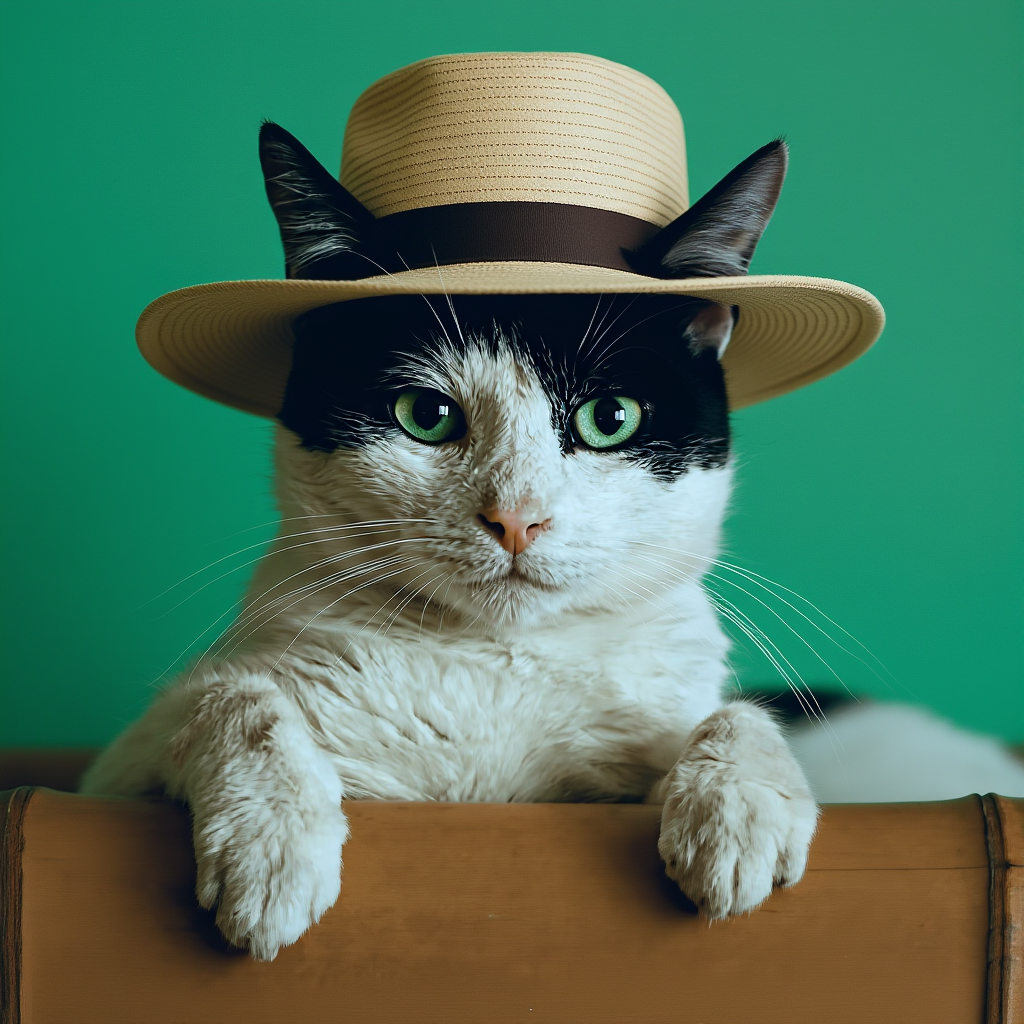

In [20]:
from IPython.display import display
display(image)